In [143]:
#Imports the libraries and read the data files

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os, sys, email
import gensim
from gensim.models import Doc2Vec
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from string import punctuation
import timeit
from sklearn.cluster import KMeans
from sklearn import metrics
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
start = timeit.default_timer()

emails_df = pd.read_csv('emails.csv', nrows=10000)

#### Parse each files to the dataframes and convert each field to the dataframe's columns. 

In [144]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [145]:
#Data Preparation
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df['Subjcontent'] = emails_df['Subject'] + " " + emails_df['content']
emails_df.head(5)

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,Subjcontent
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,Re: Traveling to have a business meeting takes...
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,Re: test test successful. way to go!!!
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,"Randy,\n\n Can you send me a schedule of the ..."
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,Re: Hello Let's shoot for Tuesday at 11:45.


#### Perform data cleaning by removing html tags and punctuations. Also, remove stop words and apply stemming. 

In [130]:
#Removing html tags
def remove_tags(text):
    return re.sub(r'<.*?>','', str(text))

#Removing punctuation
def remove_punctuation(text):
    return ''.join(c for c in text if c not in punctuation)

#Data cleaning
def email_cleaning(text):
    email = text.lower()
    email = remove_tags(email)
    email = remove_punctuation(email)
    # clean and tokenize document string
    email_content = email.split()
    # remove urls
    remove_urls = [i for i in email_content if 'http' not in i]
    # remove email addresses
    remove_emailadd = [i for i in remove_urls if '@' not in i]
    return remove_emailadd

#Data Pre-processing
def preprocessing(text):
    # remove stop words from tokens
    stopped_tokens = [i for i in clean_content if not i in stop_words]
    # remove numbers
    number_tokens = [re.sub(r'[\d]', ' ', i) for i in stopped_tokens]
    number_tokens = ' '.join(number_tokens).split()
     # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in number_tokens]
    # remove empty
    length_tokens = [i for i in stemmed_tokens if len(i) > 1]
    return length_tokens


In [131]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content = []
texts = []
j=0
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
p_stemmer = PorterStemmer()
for em in emails_df.Subjcontent:           
    #Data cleaning
    clean_content = email_cleaning(em)
    
    #Pre-processing
    processed_email = preprocessing(clean_content)
    
    # add tokens to list
    all_content.append(LabeledSentence1(processed_email,[j]))
    j+=1


#### Input the data in the Doc2Vec model for creating the vector of the documents. Save the model. Also, find the most similare of a document.

In [132]:
model = Doc2Vec(all_content, size = 1000, window = 1, min_count = 0, workers=3)
model.save('doc2vec.model')

In [133]:
d2v_model = Doc2Vec.load('doc2vec.model')
# shows the similar docs with id = 99
print (d2v_model.docvecs.most_similar(1))
#print(all_content[1])
#print(all_content[899])

[(286, 0.9483916163444519), (899, 0.908099889755249), (191, 0.7803093194961548), (489, 0.7695151567459106), (2694, 0.7693964242935181), (8074, 0.7633828520774841), (2404, 0.7611870765686035), (32, 0.7587264180183411), (9692, 0.7476165294647217), (623, 0.7468051910400391)]


#### Apply K_mean clustering on the Doc2Vec model. 

In [134]:
kmeans_model = KMeans(n_clusters=5, init='k-means++', max_iter=100)  
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
centroids = kmeans_model.cluster_centers_
labels=kmeans_model.labels_.tolist()
cluster_info = {'sentence': emails_df.Subjcontent, 'cluster' : labels}
sentenceDF = pd.DataFrame(cluster_info, columns = ['sentence','cluster'])

#### Plot the clustering graph.

In [135]:
l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)

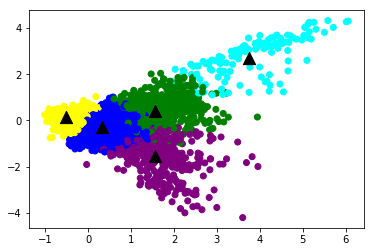

In [136]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080","#00FFFF"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [137]:
plt.savefig('ClusteringResult.png') #Save hthe graph